In [1]:
__authors__ = "Akshay Agarwal, Manish Das, Jaro Habr, Parag Kanade"
__version__ = "XCS229ii, Stanford, Spring 2021"

# Transformers - Trans-U-Net

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


## Experiment 51 - Batch size 24

In [35]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_23_1640", "trans_u_net", "TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs24_128"
)

# AZURE_PATH = os.path.join(
#     EXPORT_DIR, "trans_u_net", "original", "TU_ISIC_224_pretrain_R50-ViT-B_16_skip3_10k_epo10_bs2_224"
# )

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_23_1640/trans_u_net/TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs24_128


In [36]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer
from transformers.trans_u_net.my_trainer import TransUNetLightning

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [38]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [39]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


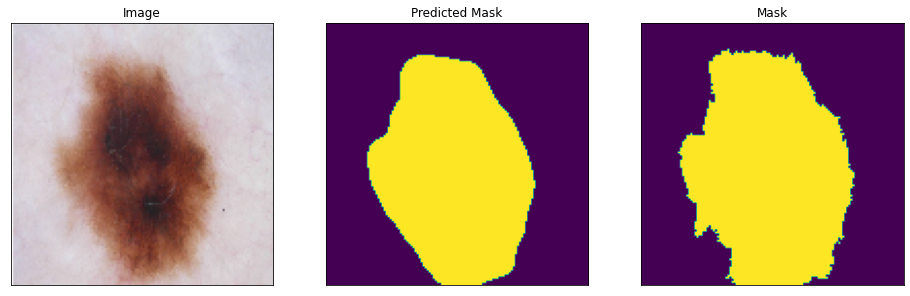

In [40]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [41]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [42]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 7min 20s, sys: 35.5 s, total: 7min 56s
Wall time: 2min 56s


In [43]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 13.9 s, sys: 35.3 ms, total: 13.9 s
Wall time: 13.9 s


{'n_images': 300,
 'n_true_positives': 936564,
 'n_true_positives_%': 0.8240825064474661,
 'n_true_negatives': 3642226,
 'n_true_negatives_%': 0.9638815605443872,
 'n_false_positives': 136481,
 'n_false_negatives': 199929,
 'iou_score': 0.7313968180511187,
 'threshold_jaccard_index': 0.6402049079112515,
 'jaccard_similarity_index': 0.7313968180511187,
 'dice': 0.8129863010363196,
 'f1_score': 0.4064931505181598,
 'sensitivity': 0.8975969134732351,
 'specificity': 0.9675807157417753,
 'accuracy': 0.9315572102864583}

## Experiment 52 - Batch size 16

In [5]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_24_1413", "trans_u_net", "TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs16_128"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_24_1413/trans_u_net/TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs16_128


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer
from transformers.trans_u_net.my_trainer import TransUNetLightning

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

Segmentation Models: using `tf.keras` framework.


<All keys matched successfully>

In [8]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [9]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


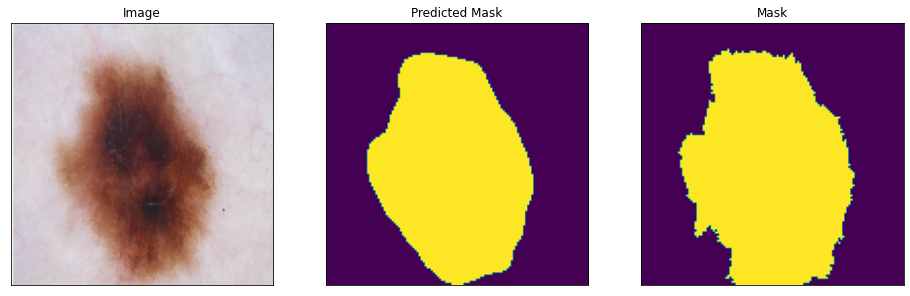

In [10]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [11]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [12]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 3min 47s, sys: 26.5 s, total: 4min 14s
Wall time: 2min 21s


In [13]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 13.6 s, sys: 25.6 ms, total: 13.6 s
Wall time: 13.7 s


{'n_images': 300,
 'n_true_positives': 913003,
 'n_true_positives_%': 0.8033511865009287,
 'n_true_negatives': 3663568,
 'n_true_negatives_%': 0.9695295242526081,
 'n_false_positives': 115139,
 'n_false_negatives': 223490,
 'iou_score': 0.7265301437734801,
 'threshold_jaccard_index': 0.6440089296022783,
 'jaccard_similarity_index': 0.7265301437734801,
 'dice': 0.8085380434653344,
 'f1_score': 0.4042690217326672,
 'sensitivity': 0.8821538742318868,
 'specificity': 0.9728757120887707,
 'accuracy': 0.9311057535807291}

## Experiment 53 - Batch size 4

In [14]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_24_2023", "trans_u_net"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_24_2023/trans_u_net


In [15]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer
from transformers.trans_u_net.my_trainer import TransUNetLightning

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [18]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


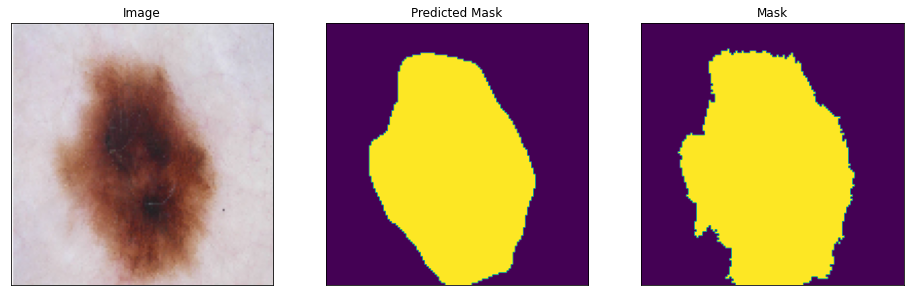

In [19]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [20]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [21]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 3min 51s, sys: 27.8 s, total: 4min 19s
Wall time: 2min 24s


In [22]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 14.1 s, sys: 61.8 ms, total: 14.2 s
Wall time: 14.4 s


{'n_images': 300,
 'n_true_positives': 945951,
 'n_true_positives_%': 0.8323421261723566,
 'n_true_negatives': 3692248,
 'n_true_negatives_%': 0.9771194220668604,
 'n_false_positives': 86459,
 'n_false_negatives': 190542,
 'iou_score': 0.7827224830274137,
 'threshold_jaccard_index': 0.7105225314013147,
 'jaccard_similarity_index': 0.7827224830274137,
 'dice': 0.8603264891580344,
 'f1_score': 0.4301632445790172,
 'sensitivity': 0.8883096365748664,
 'specificity': 0.9749237690290219,
 'accuracy': 0.9436440022786459}

## Experiment 54 - Adam, Batch size 4

In [23]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_25_0103", "trans_u_net"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_25_0103/trans_u_net


In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer
from transformers.trans_u_net.my_trainer import TransUNetLightning

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [26]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [27]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


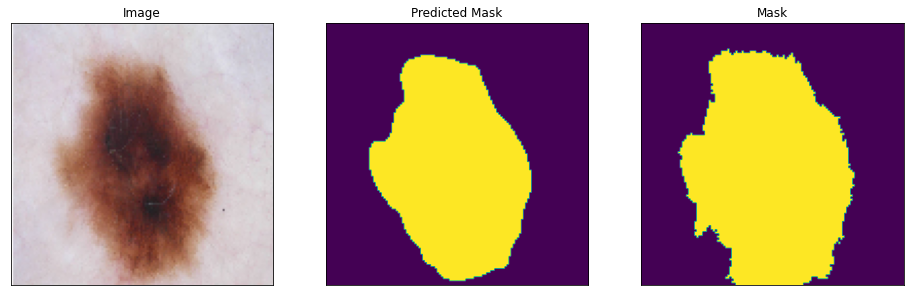

In [28]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [29]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [30]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 3min 58s, sys: 29.9 s, total: 4min 28s
Wall time: 2min 30s


In [31]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 13.8 s, sys: 61.3 ms, total: 13.9 s
Wall time: 14 s


{'n_images': 300,
 'n_true_positives': 975721,
 'n_true_positives_%': 0.8585367441770428,
 'n_true_negatives': 3718546,
 'n_true_negatives_%': 0.9840789455228998,
 'n_false_positives': 60161,
 'n_false_negatives': 160772,
 'iou_score': 0.809523162358353,
 'threshold_jaccard_index': 0.7492227266364586,
 'jaccard_similarity_index': 0.809523162358353,
 'dice': 0.8823495365250805,
 'f1_score': 0.44117476826254026,
 'sensitivity': 0.8879385926458664,
 'specificity': 0.9812377524406452,
 'accuracy': 0.9550510660807292}

### Full resolution metrics

In [ ]:
full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True)
print(len(full_size_test_images))

In [ ]:
import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        full_size_predicted_mask = cv2.resize(src=predicted_masks[index], dsize=(width, height), interpolation=cv2.INTER_NEAREST)
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        full_size_predicted_masks.append(full_size_predicted_mask)

In [ ]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [ ]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=full_size_predicted_masks
)

metrics